In [146]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('family_data.csv')

In [6]:
sample = pd.read_csv('sample_submission.csv')

In [3]:
df.head(5)

,family_id,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
0,0,52,38,12,82,33,75,64,76,10,28,4
1,1,26,4,82,5,11,47,38,6,66,61,4
2,2,100,54,25,12,27,82,10,89,80,33,3
3,3,2,95,1,96,32,6,40,31,9,59,2
4,4,53,1,47,93,26,3,46,16,42,39,4


### Costs and Constraints

In [4]:
def pref_cost(df):
    df_cost=df.copy()
    df_cost['wildcard_choice'] = 0
    for i in range(len(df_cost)):
        n = df_cost.iloc[i,11]
        df_cost.iloc[i,1]=0          #ch0
        df_cost.iloc[i,2]=50          #ch1
        df_cost.iloc[i,3]=50+(9*n)          #ch2
        df_cost.iloc[i,4]=100+(9*n)          #ch3
        df_cost.iloc[i,5]=200+(9*n)          #ch4
        df_cost.iloc[i,6]=200+(18*n)          #ch5
        df_cost.iloc[i,7]=300+(18*n)          #ch6
        df_cost.iloc[i,8]=300+(36*n)          #ch7
        df_cost.iloc[i,9]=400+(36*n)          #ch8
        df_cost.iloc[i,10]=500+(36*n)+(199*n)          #ch9
        df_cost.iloc[i,12]=500+(36*n)+(398*n)          #ch10-wildcard
    return df_cost.drop(columns='n_people')

In [71]:
def acct_pen(df):
    cost=0
    prev_occup=int(occu_df[occu_df.assigned_day==100]['n_people']) #because Nd(100)==Nd(101)
    acct_cost=0
    for index, row in df.iterrows():
        o = row['n_people']
        #print(o, '-', prev_occup)
        power = 0.5 + (abs(o - prev_occup)/50)
        acct_cost += ((o - 125)/400)*o**power
        prev_occup = o
    return acct_cost        

In [72]:
def day_constraint(df):
    arr = df.groupby('assigned_day')['n_people'].sum().values
    for i in arr:
        if i < 125 or i >300:
            print (f'number of families less')
            break
    return arr

In [73]:
import random
n = 100 # no of days
days = list(range(n,0,-1))
occu_df = pd.DataFrame(days)
occu_df.columns=['days']
occupancy = [random.randint(125,301) for x in range(100)]
occu_df['occupancy']=occupancy

In [74]:
sample_sub = pd.merge(sample, df[['family_id','n_people']], on='family_id', how='inner')
sample_sub.shape

(5000, 3)

In [75]:
occu_df = sample_sub.groupby('assigned_day')['n_people'].sum().reset_index()
occu_df.head()

,assigned_day,n_people
0,1,203
1,2,230
2,3,206
3,4,217
4,5,221


In [76]:
acct_cost=acct_pen(occu_df)
acct_cost

1847.2069474668704

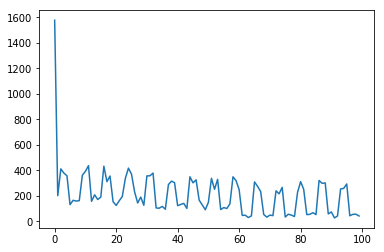

In [138]:
df[['family_id','choice_0', 'n_people']].groupby('choice_0')['n_people'].sum().reset_index()['n_people'].plot()

In [140]:
df[df.choice_0==1]['n_people'].sum()

1576

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a530400>]],
      dtype=object)

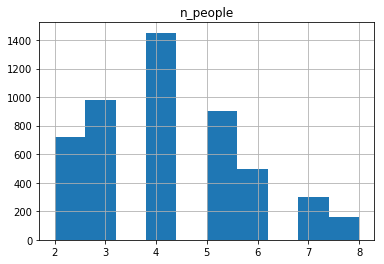

In [17]:
df[['n_people']].hist()

 Higher number of people in the family, higher cost to move them

There should be "moving weight" based on the size of the family

In [57]:
a = day_constraint(sample_sub)

In [77]:
cost = pref_cost(df)

In [133]:
def pref_cost_family(cost_df, family_df, output_df):
    tot_pref_cost_val = 0
    for index, row in output_df.iterrows():
        f_id = row['family_id']
        a_day = row['assigned_day']
        f_choices = family_df[family_df.family_id==f_id].drop(columns=['n_people', 'family_id']).values[0]
        ch_id = 0
        for i, e in enumerate(f_choices):   
            if e==a_day:
                ch_id = i + 1
                break
            else:
                ch_id = 11 #wildcard choice
        pref_cost_val = cost_df.iloc[f_id, ch_id]
        tot_pref_cost_val+=pref_cost_val
        print(f'cost for family {f_id} is {pref_cost_val} because of choice {ch_id} which was day {a_day}')
    return tot_pref_cost_val

In [134]:
tot_pref_cost_val=pref_cost_family(cost, df, sample)

cost for family 0 is 2236 because of choice 11 which was day 100
cost for family 1 is 2236 because of choice 11 which was day 99
cost for family 2 is 1802 because of choice 11 which was day 98
cost for family 3 is 1368 because of choice 11 which was day 97
cost for family 4 is 2236 because of choice 11 which was day 96
cost for family 5 is 2236 because of choice 11 which was day 95
cost for family 6 is 1368 because of choice 11 which was day 94
cost for family 7 is 2670 because of choice 11 which was day 93
cost for family 8 is 2236 because of choice 11 which was day 92
cost for family 9 is 3538 because of choice 11 which was day 91
cost for family 10 is 3538 because of choice 11 which was day 90
cost for family 11 is 552 because of choice 8 which was day 89
cost for family 12 is 3104 because of choice 11 which was day 88
cost for family 13 is 1368 because of choice 11 which was day 87
cost for family 14 is 1368 because of choice 11 which was day 86
cost for family 15 is 1368 because o

cost for family 152 is 1368 because of choice 11 which was day 48
cost for family 153 is 1368 because of choice 11 which was day 47
cost for family 154 is 2236 because of choice 11 which was day 46
cost for family 155 is 1368 because of choice 11 which was day 45
cost for family 156 is 95 because of choice 3 which was day 44
cost for family 157 is 1802 because of choice 11 which was day 43
cost for family 158 is 3104 because of choice 11 which was day 42
cost for family 159 is 3104 because of choice 11 which was day 41
cost for family 160 is 0 because of choice 1 which was day 40
cost for family 161 is 2236 because of choice 11 which was day 39
cost for family 162 is 2670 because of choice 11 which was day 38
cost for family 163 is 2236 because of choice 11 which was day 37
cost for family 164 is 3104 because of choice 11 which was day 36
cost for family 165 is 3538 because of choice 11 which was day 35
cost for family 166 is 2236 because of choice 11 which was day 34
cost for family 1

cost for family 312 is 1368 because of choice 11 which was day 88
cost for family 313 is 2670 because of choice 11 which was day 87
cost for family 314 is 1802 because of choice 11 which was day 86
cost for family 315 is 2236 because of choice 11 which was day 85
cost for family 316 is 2670 because of choice 11 which was day 84
cost for family 317 is 1802 because of choice 11 which was day 83
cost for family 318 is 86 because of choice 3 which was day 82
cost for family 319 is 245 because of choice 5 which was day 81
cost for family 320 is 2670 because of choice 11 which was day 80
cost for family 321 is 2670 because of choice 11 which was day 79
cost for family 322 is 2236 because of choice 11 which was day 78
cost for family 323 is 2236 because of choice 11 which was day 77
cost for family 324 is 1802 because of choice 11 which was day 76
cost for family 325 is 1368 because of choice 11 which was day 75
cost for family 326 is 2236 because of choice 11 which was day 74
cost for family

cost for family 470 is 1368 because of choice 11 which was day 30
cost for family 471 is 2236 because of choice 11 which was day 29
cost for family 472 is 2236 because of choice 11 which was day 28
cost for family 473 is 1802 because of choice 11 which was day 27
cost for family 474 is 2670 because of choice 11 which was day 26
cost for family 475 is 2670 because of choice 11 which was day 25
cost for family 476 is 1802 because of choice 11 which was day 24
cost for family 477 is 2236 because of choice 11 which was day 23
cost for family 478 is 2670 because of choice 11 which was day 22
cost for family 479 is 1368 because of choice 11 which was day 21
cost for family 480 is 1802 because of choice 11 which was day 20
cost for family 481 is 2670 because of choice 11 which was day 19
cost for family 482 is 1368 because of choice 11 which was day 18
cost for family 483 is 2670 because of choice 11 which was day 17
cost for family 484 is 2236 because of choice 11 which was day 16
cost for f

cost for family 621 is 2236 because of choice 11 which was day 79
cost for family 622 is 2236 because of choice 11 which was day 78
cost for family 623 is 1802 because of choice 11 which was day 77
cost for family 624 is 2670 because of choice 11 which was day 76
cost for family 625 is 2670 because of choice 11 which was day 75
cost for family 626 is 2236 because of choice 11 which was day 74
cost for family 627 is 2670 because of choice 11 which was day 73
cost for family 628 is 3104 because of choice 11 which was day 72
cost for family 629 is 1802 because of choice 11 which was day 71
cost for family 630 is 3538 because of choice 11 which was day 70
cost for family 631 is 1802 because of choice 11 which was day 69
cost for family 632 is 2236 because of choice 11 which was day 68
cost for family 633 is 3538 because of choice 11 which was day 67
cost for family 634 is 1802 because of choice 11 which was day 66
cost for family 635 is 2670 because of choice 11 which was day 65
cost for f

cost for family 771 is 2670 because of choice 11 which was day 29
cost for family 772 is 2236 because of choice 11 which was day 28
cost for family 773 is 1368 because of choice 11 which was day 27
cost for family 774 is 0 because of choice 1 which was day 26
cost for family 775 is 1368 because of choice 11 which was day 25
cost for family 776 is 2236 because of choice 11 which was day 24
cost for family 777 is 1368 because of choice 11 which was day 23
cost for family 778 is 2236 because of choice 11 which was day 22
cost for family 779 is 2236 because of choice 11 which was day 21
cost for family 780 is 2236 because of choice 11 which was day 20
cost for family 781 is 136 because of choice 4 which was day 19
cost for family 782 is 1368 because of choice 11 which was day 18
cost for family 783 is 1368 because of choice 11 which was day 17
cost for family 784 is 1802 because of choice 11 which was day 16
cost for family 785 is 3972 because of choice 11 which was day 15
cost for family 

cost for family 933 is 3104 because of choice 11 which was day 67
cost for family 934 is 1368 because of choice 11 which was day 66
cost for family 935 is 1802 because of choice 11 which was day 65
cost for family 936 is 1802 because of choice 11 which was day 64
cost for family 937 is 2236 because of choice 11 which was day 63
cost for family 938 is 3104 because of choice 11 which was day 62
cost for family 939 is 3972 because of choice 11 which was day 61
cost for family 940 is 2670 because of choice 11 which was day 60
cost for family 941 is 2236 because of choice 11 which was day 59
cost for family 942 is 1802 because of choice 11 which was day 58
cost for family 943 is 3104 because of choice 11 which was day 57
cost for family 944 is 2236 because of choice 11 which was day 56
cost for family 945 is 263 because of choice 5 which was day 55
cost for family 946 is 0 because of choice 1 which was day 54
cost for family 947 is 3104 because of choice 11 which was day 53
cost for family 

cost for family 1088 is 2670 because of choice 11 which was day 12
cost for family 1089 is 354 because of choice 7 which was day 11
cost for family 1090 is 3538 because of choice 11 which was day 10
cost for family 1091 is 2236 because of choice 11 which was day 9
cost for family 1092 is 2670 because of choice 11 which was day 8
cost for family 1093 is 2236 because of choice 11 which was day 7
cost for family 1094 is 3104 because of choice 11 which was day 6
cost for family 1095 is 3538 because of choice 11 which was day 5
cost for family 1096 is 2236 because of choice 11 which was day 4
cost for family 1097 is 3538 because of choice 11 which was day 3
cost for family 1098 is 970 because of choice 10 which was day 2
cost for family 1099 is 272 because of choice 5 which was day 1
cost for family 1100 is 2236 because of choice 11 which was day 100
cost for family 1101 is 1368 because of choice 11 which was day 99
cost for family 1102 is 1802 because of choice 11 which was day 98
cost for

cost for family 1259 is 1368 because of choice 11 which was day 41
cost for family 1260 is 1802 because of choice 11 which was day 40
cost for family 1261 is 2236 because of choice 11 which was day 39
cost for family 1262 is 1802 because of choice 11 which was day 38
cost for family 1263 is 2236 because of choice 11 which was day 37
cost for family 1264 is 1368 because of choice 11 which was day 36
cost for family 1265 is 1802 because of choice 11 which was day 35
cost for family 1266 is 1802 because of choice 11 which was day 34
cost for family 1267 is 2236 because of choice 11 which was day 33
cost for family 1268 is 3972 because of choice 11 which was day 32
cost for family 1269 is 3104 because of choice 11 which was day 31
cost for family 1270 is 2236 because of choice 11 which was day 30
cost for family 1271 is 2670 because of choice 11 which was day 29
cost for family 1272 is 2236 because of choice 11 which was day 28
cost for family 1273 is 0 because of choice 1 which was day 27

cost for family 1411 is 3104 because of choice 11 which was day 89
cost for family 1412 is 2236 because of choice 11 which was day 88
cost for family 1413 is 2670 because of choice 11 which was day 87
cost for family 1414 is 2236 because of choice 11 which was day 86
cost for family 1415 is 1802 because of choice 11 which was day 85
cost for family 1416 is 3538 because of choice 11 which was day 84
cost for family 1417 is 2236 because of choice 11 which was day 83
cost for family 1418 is 2670 because of choice 11 which was day 82
cost for family 1419 is 1368 because of choice 11 which was day 81
cost for family 1420 is 3972 because of choice 11 which was day 80
cost for family 1421 is 3104 because of choice 11 which was day 79
cost for family 1422 is 3972 because of choice 11 which was day 78
cost for family 1423 is 1205 because of choice 10 which was day 77
cost for family 1424 is 1368 because of choice 11 which was day 76
cost for family 1425 is 336 because of choice 7 which was day 

cost for family 1569 is 1802 because of choice 11 which was day 31
cost for family 1570 is 3104 because of choice 11 which was day 30
cost for family 1571 is 2670 because of choice 11 which was day 29
cost for family 1572 is 3972 because of choice 11 which was day 28
cost for family 1573 is 2236 because of choice 11 which was day 27
cost for family 1574 is 1802 because of choice 11 which was day 26
cost for family 1575 is 254 because of choice 6 which was day 25
cost for family 1576 is 1368 because of choice 11 which was day 24
cost for family 1577 is 2236 because of choice 11 which was day 23
cost for family 1578 is 1802 because of choice 11 which was day 22
cost for family 1579 is 2236 because of choice 11 which was day 21
cost for family 1580 is 2670 because of choice 11 which was day 20
cost for family 1581 is 1802 because of choice 11 which was day 19
cost for family 1582 is 3538 because of choice 11 which was day 18
cost for family 1583 is 2236 because of choice 11 which was day 

cost for family 1700 is 2670 because of choice 11 which was day 100
cost for family 1701 is 3104 because of choice 11 which was day 99
cost for family 1702 is 3104 because of choice 11 which was day 98
cost for family 1703 is 1802 because of choice 11 which was day 97
cost for family 1704 is 2670 because of choice 11 which was day 96
cost for family 1705 is 2670 because of choice 11 which was day 95
cost for family 1706 is 2670 because of choice 11 which was day 94
cost for family 1707 is 1802 because of choice 11 which was day 93
cost for family 1708 is 1368 because of choice 11 which was day 92
cost for family 1709 is 1802 because of choice 11 which was day 91
cost for family 1710 is 2670 because of choice 11 which was day 90
cost for family 1711 is 2670 because of choice 11 which was day 89
cost for family 1712 is 2236 because of choice 11 which was day 88
cost for family 1713 is 3104 because of choice 11 which was day 87
cost for family 1714 is 2670 because of choice 11 which was d

cost for family 1834 is 1802 because of choice 11 which was day 66
cost for family 1835 is 2236 because of choice 11 which was day 65
cost for family 1836 is 2236 because of choice 11 which was day 64
cost for family 1837 is 1802 because of choice 11 which was day 63
cost for family 1838 is 2670 because of choice 11 which was day 62
cost for family 1839 is 3104 because of choice 11 which was day 61
cost for family 1840 is 3972 because of choice 11 which was day 60
cost for family 1841 is 1802 because of choice 11 which was day 59
cost for family 1842 is 2236 because of choice 11 which was day 58
cost for family 1843 is 1802 because of choice 11 which was day 57
cost for family 1844 is 2236 because of choice 11 which was day 56
cost for family 1845 is 0 because of choice 1 which was day 55
cost for family 1846 is 2236 because of choice 11 which was day 54
cost for family 1847 is 516 because of choice 8 which was day 53
cost for family 1848 is 3538 because of choice 11 which was day 52
c

cost for family 1990 is 1368 because of choice 11 which was day 10
cost for family 1991 is 2236 because of choice 11 which was day 9
cost for family 1992 is 2670 because of choice 11 which was day 8
cost for family 1993 is 2670 because of choice 11 which was day 7
cost for family 1994 is 1802 because of choice 11 which was day 6
cost for family 1995 is 3972 because of choice 11 which was day 5
cost for family 1996 is 2236 because of choice 11 which was day 4
cost for family 1997 is 2236 because of choice 11 which was day 3
cost for family 1998 is 1802 because of choice 11 which was day 2
cost for family 1999 is 2670 because of choice 11 which was day 1
cost for family 2000 is 2670 because of choice 11 which was day 100
cost for family 2001 is 2670 because of choice 11 which was day 99
cost for family 2002 is 3104 because of choice 11 which was day 98
cost for family 2003 is 2670 because of choice 11 which was day 97
cost for family 2004 is 3104 because of choice 11 which was day 96
cos

cost for family 2148 is 3538 because of choice 11 which was day 52
cost for family 2149 is 2236 because of choice 11 which was day 51
cost for family 2150 is 1802 because of choice 11 which was day 50
cost for family 2151 is 2236 because of choice 11 which was day 49
cost for family 2152 is 2670 because of choice 11 which was day 48
cost for family 2153 is 218 because of choice 5 which was day 47
cost for family 2154 is 3538 because of choice 11 which was day 46
cost for family 2155 is 1802 because of choice 11 which was day 45
cost for family 2156 is 354 because of choice 7 which was day 44
cost for family 2157 is 1368 because of choice 11 which was day 43
cost for family 2158 is 2670 because of choice 11 which was day 42
cost for family 2159 is 2670 because of choice 11 which was day 41
cost for family 2160 is 1368 because of choice 11 which was day 40
cost for family 2161 is 50 because of choice 2 which was day 39
cost for family 2162 is 2236 because of choice 11 which was day 38
co

cost for family 2278 is 2236 because of choice 11 which was day 22
cost for family 2279 is 1910 because of choice 10 which was day 21
cost for family 2280 is 1368 because of choice 11 which was day 20
cost for family 2281 is 2236 because of choice 11 which was day 19
cost for family 2282 is 2236 because of choice 11 which was day 18
cost for family 2283 is 2670 because of choice 11 which was day 17
cost for family 2284 is 2670 because of choice 11 which was day 16
cost for family 2285 is 390 because of choice 7 which was day 15
cost for family 2286 is 2236 because of choice 11 which was day 14
cost for family 2287 is 3104 because of choice 11 which was day 13
cost for family 2288 is 1802 because of choice 11 which was day 12
cost for family 2289 is 552 because of choice 8 which was day 11
cost for family 2290 is 1675 because of choice 10 which was day 10
cost for family 2291 is 1368 because of choice 11 which was day 9
cost for family 2292 is 1802 because of choice 11 which was day 8
c

cost for family 2532 is 2236 because of choice 11 which was day 68
cost for family 2533 is 444 because of choice 8 which was day 67
cost for family 2534 is 2236 because of choice 11 which was day 66
cost for family 2535 is 2236 because of choice 11 which was day 65
cost for family 2536 is 1675 because of choice 10 which was day 64
cost for family 2537 is 1368 because of choice 11 which was day 63
cost for family 2538 is 2236 because of choice 11 which was day 62
cost for family 2539 is 272 because of choice 6 which was day 61
cost for family 2540 is 2670 because of choice 11 which was day 60
cost for family 2541 is 3104 because of choice 11 which was day 59
cost for family 2542 is 1368 because of choice 11 which was day 58
cost for family 2543 is 3104 because of choice 11 which was day 57
cost for family 2544 is 1802 because of choice 11 which was day 56
cost for family 2545 is 1368 because of choice 11 which was day 55
cost for family 2546 is 2236 because of choice 11 which was day 54

cost for family 2668 is 1368 because of choice 11 which was day 32
cost for family 2669 is 2236 because of choice 11 which was day 31
cost for family 2670 is 1368 because of choice 11 which was day 30
cost for family 2671 is 2670 because of choice 11 which was day 29
cost for family 2672 is 1802 because of choice 11 which was day 28
cost for family 2673 is 2236 because of choice 11 which was day 27
cost for family 2674 is 3538 because of choice 11 which was day 26
cost for family 2675 is 2670 because of choice 11 which was day 25
cost for family 2676 is 3104 because of choice 11 which was day 24
cost for family 2677 is 2670 because of choice 11 which was day 23
cost for family 2678 is 3538 because of choice 11 which was day 22
cost for family 2679 is 1368 because of choice 11 which was day 21
cost for family 2680 is 172 because of choice 4 which was day 20
cost for family 2681 is 2670 because of choice 11 which was day 19
cost for family 2682 is 3104 because of choice 11 which was day 

cost for family 2827 is 2236 because of choice 11 which was day 73
cost for family 2828 is 2236 because of choice 11 which was day 72
cost for family 2829 is 3538 because of choice 11 which was day 71
cost for family 2830 is 2380 because of choice 10 which was day 70
cost for family 2831 is 2670 because of choice 11 which was day 69
cost for family 2832 is 1802 because of choice 11 which was day 68
cost for family 2833 is 1802 because of choice 11 which was day 67
cost for family 2834 is 616 because of choice 9 which was day 66
cost for family 2835 is 3538 because of choice 11 which was day 65
cost for family 2836 is 1802 because of choice 11 which was day 64
cost for family 2837 is 3104 because of choice 11 which was day 63
cost for family 2838 is 1368 because of choice 11 which was day 62
cost for family 2839 is 2670 because of choice 11 which was day 61
cost for family 2840 is 1802 because of choice 11 which was day 60
cost for family 2841 is 2670 because of choice 11 which was day 

cost for family 2982 is 2236 because of choice 11 which was day 18
cost for family 2983 is 3538 because of choice 11 which was day 17
cost for family 2984 is 2236 because of choice 11 which was day 16
cost for family 2985 is 1802 because of choice 11 which was day 15
cost for family 2986 is 1368 because of choice 11 which was day 14
cost for family 2987 is 2670 because of choice 11 which was day 13
cost for family 2988 is 1368 because of choice 11 which was day 12
cost for family 2989 is 1368 because of choice 11 which was day 11
cost for family 2990 is 2670 because of choice 11 which was day 10
cost for family 2991 is 3538 because of choice 11 which was day 9
cost for family 2992 is 0 because of choice 1 which was day 8
cost for family 2993 is 3538 because of choice 11 which was day 7
cost for family 2994 is 1368 because of choice 11 which was day 6
cost for family 2995 is 1368 because of choice 11 which was day 5
cost for family 2996 is 3104 because of choice 11 which was day 4
cost 

cost for family 3158 is 970 because of choice 10 which was day 42
cost for family 3159 is 1368 because of choice 11 which was day 41
cost for family 3160 is 1368 because of choice 11 which was day 40
cost for family 3161 is 3538 because of choice 11 which was day 39
cost for family 3162 is 1368 because of choice 11 which was day 38
cost for family 3163 is 2670 because of choice 11 which was day 37
cost for family 3164 is 2236 because of choice 11 which was day 36
cost for family 3165 is 1802 because of choice 11 which was day 35
cost for family 3166 is 2236 because of choice 11 which was day 34
cost for family 3167 is 544 because of choice 9 which was day 33
cost for family 3168 is 3104 because of choice 11 which was day 32
cost for family 3169 is 3104 because of choice 11 which was day 31
cost for family 3170 is 2670 because of choice 11 which was day 30
cost for family 3171 is 2236 because of choice 11 which was day 29
cost for family 3172 is 2670 because of choice 11 which was day 2

cost for family 3326 is 3538 because of choice 11 which was day 74
cost for family 3327 is 1368 because of choice 11 which was day 73
cost for family 3328 is 2236 because of choice 11 which was day 72
cost for family 3329 is 1802 because of choice 11 which was day 71
cost for family 3330 is 2670 because of choice 11 which was day 70
cost for family 3331 is 2236 because of choice 11 which was day 69
cost for family 3332 is 3972 because of choice 11 which was day 68
cost for family 3333 is 2670 because of choice 11 which was day 67
cost for family 3334 is 1802 because of choice 11 which was day 66
cost for family 3335 is 3104 because of choice 11 which was day 65
cost for family 3336 is 2670 because of choice 11 which was day 64
cost for family 3337 is 1368 because of choice 11 which was day 63
cost for family 3338 is 2236 because of choice 11 which was day 62
cost for family 3339 is 3538 because of choice 11 which was day 61
cost for family 3340 is 1368 because of choice 11 which was da

cost for family 3496 is 50 because of choice 2 which was day 4
cost for family 3497 is 290 because of choice 6 which was day 3
cost for family 3498 is 2236 because of choice 11 which was day 2
cost for family 3499 is 3538 because of choice 11 which was day 1
cost for family 3500 is 1368 because of choice 11 which was day 100
cost for family 3501 is 2236 because of choice 11 which was day 99
cost for family 3502 is 2670 because of choice 11 which was day 98
cost for family 3503 is 1802 because of choice 11 which was day 97
cost for family 3504 is 3104 because of choice 11 which was day 96
cost for family 3505 is 2236 because of choice 11 which was day 95
cost for family 3506 is 1368 because of choice 11 which was day 94
cost for family 3507 is 1802 because of choice 11 which was day 93
cost for family 3508 is 95 because of choice 3 which was day 92
cost for family 3509 is 1802 because of choice 11 which was day 91
cost for family 3510 is 2236 because of choice 11 which was day 90
cost f

cost for family 3673 is 272 because of choice 6 which was day 27
cost for family 3674 is 2670 because of choice 11 which was day 26
cost for family 3675 is 2670 because of choice 11 which was day 25
cost for family 3676 is 3104 because of choice 11 which was day 24
cost for family 3677 is 1368 because of choice 11 which was day 23
cost for family 3678 is 1368 because of choice 11 which was day 22
cost for family 3679 is 0 because of choice 1 which was day 21
cost for family 3680 is 3538 because of choice 11 which was day 20
cost for family 3681 is 1802 because of choice 11 which was day 19
cost for family 3682 is 2670 because of choice 11 which was day 18
cost for family 3683 is 3972 because of choice 11 which was day 17
cost for family 3684 is 2670 because of choice 11 which was day 16
cost for family 3685 is 2236 because of choice 11 which was day 15
cost for family 3686 is 154 because of choice 4 which was day 14
cost for family 3687 is 1802 because of choice 11 which was day 13
cos

cost for family 3846 is 3104 because of choice 11 which was day 54
cost for family 3847 is 1802 because of choice 11 which was day 53
cost for family 3848 is 1802 because of choice 11 which was day 52
cost for family 3849 is 2236 because of choice 11 which was day 51
cost for family 3850 is 3104 because of choice 11 which was day 50
cost for family 3851 is 2670 because of choice 11 which was day 49
cost for family 3852 is 2670 because of choice 11 which was day 48
cost for family 3853 is 1802 because of choice 11 which was day 47
cost for family 3854 is 2236 because of choice 11 which was day 46
cost for family 3855 is 2670 because of choice 11 which was day 45
cost for family 3856 is 480 because of choice 8 which was day 44
cost for family 3857 is 2236 because of choice 11 which was day 43
cost for family 3858 is 1802 because of choice 11 which was day 42
cost for family 3859 is 1368 because of choice 11 which was day 41
cost for family 3860 is 2236 because of choice 11 which was day 

cost for family 4016 is 1368 because of choice 11 which was day 84
cost for family 4017 is 1368 because of choice 11 which was day 83
cost for family 4018 is 1802 because of choice 11 which was day 82
cost for family 4019 is 544 because of choice 9 which was day 81
cost for family 4020 is 426 because of choice 7 which was day 80
cost for family 4021 is 3104 because of choice 11 which was day 79
cost for family 4022 is 272 because of choice 6 which was day 78
cost for family 4023 is 2236 because of choice 11 which was day 77
cost for family 4024 is 1368 because of choice 11 which was day 76
cost for family 4025 is 1802 because of choice 11 which was day 75
cost for family 4026 is 1368 because of choice 11 which was day 74
cost for family 4027 is 2236 because of choice 11 which was day 73
cost for family 4028 is 3104 because of choice 11 which was day 72
cost for family 4029 is 2670 because of choice 11 which was day 71
cost for family 4030 is 3104 because of choice 11 which was day 70
c

cost for family 4178 is 2236 because of choice 11 which was day 22
cost for family 4179 is 1368 because of choice 11 which was day 21
cost for family 4180 is 1802 because of choice 11 which was day 20
cost for family 4181 is 2236 because of choice 11 which was day 19
cost for family 4182 is 2236 because of choice 11 which was day 18
cost for family 4183 is 2670 because of choice 11 which was day 17
cost for family 4184 is 1802 because of choice 11 which was day 16
cost for family 4185 is 1368 because of choice 11 which was day 15
cost for family 4186 is 0 because of choice 1 which was day 14
cost for family 4187 is 1368 because of choice 11 which was day 13
cost for family 4188 is 1368 because of choice 11 which was day 12
cost for family 4189 is 3104 because of choice 11 which was day 11
cost for family 4190 is 1802 because of choice 11 which was day 10
cost for family 4191 is 1368 because of choice 11 which was day 9
cost for family 4192 is 2670 because of choice 11 which was day 8
c

cost for family 4344 is 2236 because of choice 11 which was day 56
cost for family 4345 is 3104 because of choice 11 which was day 55
cost for family 4346 is 2670 because of choice 11 which was day 54
cost for family 4347 is 2236 because of choice 11 which was day 53
cost for family 4348 is 2236 because of choice 11 which was day 52
cost for family 4349 is 1802 because of choice 11 which was day 51
cost for family 4350 is 3538 because of choice 11 which was day 50
cost for family 4351 is 1802 because of choice 11 which was day 49
cost for family 4352 is 2236 because of choice 11 which was day 48
cost for family 4353 is 508 because of choice 9 which was day 47
cost for family 4354 is 2236 because of choice 11 which was day 46
cost for family 4355 is 1802 because of choice 11 which was day 45
cost for family 4356 is 1368 because of choice 11 which was day 44
cost for family 4357 is 1802 because of choice 11 which was day 43
cost for family 4358 is 2236 because of choice 11 which was day 

cost for family 4509 is 3972 because of choice 11 which was day 91
cost for family 4510 is 2670 because of choice 11 which was day 90
cost for family 4511 is 2236 because of choice 11 which was day 89
cost for family 4512 is 2236 because of choice 11 which was day 88
cost for family 4513 is 2670 because of choice 11 which was day 87
cost for family 4514 is 1802 because of choice 11 which was day 86
cost for family 4515 is 1368 because of choice 11 which was day 85
cost for family 4516 is 2670 because of choice 11 which was day 84
cost for family 4517 is 1802 because of choice 11 which was day 83
cost for family 4518 is 3972 because of choice 11 which was day 82
cost for family 4519 is 308 because of choice 6 which was day 81
cost for family 4520 is 472 because of choice 9 which was day 80
cost for family 4521 is 3538 because of choice 11 which was day 79
cost for family 4522 is 1802 because of choice 11 which was day 78
cost for family 4523 is 3104 because of choice 11 which was day 77

cost for family 4680 is 2236 because of choice 11 which was day 20
cost for family 4681 is 2236 because of choice 11 which was day 19
cost for family 4682 is 1368 because of choice 11 which was day 18
cost for family 4683 is 3538 because of choice 11 which was day 17
cost for family 4684 is 2670 because of choice 11 which was day 16
cost for family 4685 is 2236 because of choice 11 which was day 15
cost for family 4686 is 2670 because of choice 11 which was day 14
cost for family 4687 is 2670 because of choice 11 which was day 13
cost for family 4688 is 2670 because of choice 11 which was day 12
cost for family 4689 is 1802 because of choice 11 which was day 11
cost for family 4690 is 2236 because of choice 11 which was day 10
cost for family 4691 is 3538 because of choice 11 which was day 9
cost for family 4692 is 444 because of choice 8 which was day 8
cost for family 4693 is 480 because of choice 8 which was day 7
cost for family 4694 is 1802 because of choice 11 which was day 6
cos

cost for family 4852 is 1802 because of choice 11 which was day 48
cost for family 4853 is 1802 because of choice 11 which was day 47
cost for family 4854 is 3104 because of choice 11 which was day 46
cost for family 4855 is 1802 because of choice 11 which was day 45
cost for family 4856 is 2670 because of choice 11 which was day 44
cost for family 4857 is 3104 because of choice 11 which was day 43
cost for family 4858 is 1368 because of choice 11 which was day 42
cost for family 4859 is 236 because of choice 6 which was day 41
cost for family 4860 is 1802 because of choice 11 which was day 40
cost for family 4861 is 2236 because of choice 11 which was day 39
cost for family 4862 is 1802 because of choice 11 which was day 38
cost for family 4863 is 1368 because of choice 11 which was day 37
cost for family 4864 is 2670 because of choice 11 which was day 36
cost for family 4865 is 2236 because of choice 11 which was day 35
cost for family 4866 is 3972 because of choice 11 which was day 

In [147]:
#checking for each choice how many violations
cols=df.drop(columns=['family_id','n_people'])
for col in cols:
    val=[]
    arr = df.groupby(col)['n_people'].sum().reset_index()['n_people'].values
    c=0
    for i, e in enumerate(arr):
        if e < 125 or e > 300:
            c+=1
            val.append(e)
    print(f'for {col} there are {c} days which violate the constraint with mean {np.mean(val)}')

for choice_0 there are 63 days which violate the constraint with mean 216.57142857142858
for choice_1 there are 59 days which violate the constraint with mean 217.6271186440678
for choice_2 there are 68 days which violate the constraint with mean 210.2941176470588
for choice_3 there are 64 days which violate the constraint with mean 205.625
for choice_4 there are 66 days which violate the constraint with mean 213.07575757575756
for choice_5 there are 63 days which violate the constraint with mean 204.0793650793651
for choice_6 there are 63 days which violate the constraint with mean 212.34920634920636
for choice_7 there are 63 days which violate the constraint with mean 212.47619047619048
for choice_8 there are 63 days which violate the constraint with mean 210.76190476190476
for choice_9 there are 62 days which violate the constraint with mean 214.91935483870967
